In [1]:
import sys
sys.path.append("./../helper/") 
from common_imports import *
from helpers import *
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

### Load co-occurence counts

In [2]:
cc = counter('wos-econ-20k-titles-limited-cooc')

Loading wos-econ-20k-titles-limited-cooc from disk...


In [3]:
len(cc.items('t'))

1500

### How surprising are co-occurrences given their marginal propsensities?

If terms are independent, their joint probability is $P(AB) = P(A)P(B)$. The ratio $\frac{P(AB)}{P(A)P(B)}$, therefore, is a good measure of surprisingness.

However, since we don't have probabilities but counts, we need to scale them by the total word count, $T$. Thus: 
$$\frac{\frac{C(AB)}{T}}{ \frac{C(A)}{T}\frac{C(B)}{T} } = \frac{C(AB)T}{C(A)C(B)}$$

### Calculate surprisingness ratio

In [4]:
cc.counts.keys()

dict_keys([('fy', 't'), ('fj', 't'), ('fy',), ('t',), ('fj',), ('t1', 't2'), ('fy', 't1', 't2')])

In [5]:
tot = cc.counts[('t',)].sum() # sum of counts across all terms
terms = cc.items('t') # all terms

In [6]:
rats = [] # ratios
pairs = [] # pairs

for t1 in terms:
    for t2 in terms:
        if t1 == t2:
            continue # skip co-occurrences of terms with themselves
        
        ca = cc(t=t1) # count of t1
        cb = cc(t=t2) # count of t2
        cab = cc(t1=t1, t2=t2) # count of them appearing together
        
        if cab < 10 or ca < 10 or cb < 10:
            continue # skip small co-occurences

        rat = tot * cab / (ca * cb) # surprise ratio
        pairs.append( (cc.ids['t'][t1], cc.ids['t'][t2]) )
        rats.append( rat )

In [7]:
rats = np.array(rats) # turn into numpy array

### Descriptives

In [8]:
stats.describe(rats)

DescribeResult(nobs=27112, minmax=(0.7833503303544241, 5039.626865671642), mean=38.534524092067926, variance=17727.296703642423, skewness=13.520969844681726, kurtosis=292.0150554927223)

In [59]:
np.argwhere( rats > 250 ).shape # we have 722 highly surprising pairs
np.argwhere( rats <= 250 ).shape # and many more less surprising pairs

(722, 1)

<AxesSubplot:ylabel='Density'>

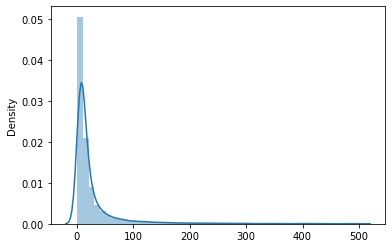

In [78]:
sns.distplot(rats[(rats>0)&(rats<500)], hist=True, kde=True)

In [79]:
np.mean(rats) # mean
np.quantile(rats, 0.9) # 90% percentile

38.534524092067926

In [14]:
from random import sample

In [96]:
tops = np.argwhere( rats > np.quantile(rats, 0.99) ).flatten()
tops = list(tops)

for i in sample( tops, 20 ):
    ai, bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    ac = cc.counts[('t',)][ai]
    bc = cc.counts[('t',)][bi]
    abc = cc.counts[('t1','t2')][(ai,bi)]
    bac = cc.counts[('t1','t2')][(bi,ai)]
    print( (at, bt, rats[i], ac, bc, abc, bac) ) # top 20 from the 99 percentile

('another', 'look', 1486.5314465408806, 75, 106, 0, 0)
('task', 'force', 1284.3733733733734, 54, 185, 0, 0)
('contingent', 'valuation', 545.5678007438571, 142, 462, 1, 13)
('iron', 'steel', 1434.1763619575254, 95, 114, 0, 0)
('unions', 'customs', 618.6990380210719, 185, 59, 0, 0)
('functional', 'forms', 1164.997124784359, 111, 94, 0, 0)
('vertical', 'integration', 664.001229067445, 115, 283, 64, 64)
('mortality', 'physical', 782.011065362841, 134, 58, 0, 0)
('puzzle', 'premium', 765.657596371882, 63, 84, 1, 0)
('revealed', 'preference', 748.5830725091289, 81, 284, 0, 0)
('budget', 'deficits', 744.6082034695678, 179, 76, 0, 0)
('less', 'developed', 2204.2275145067697, 94, 132, 0, 0)
('variable', 'instrumental', 554.4417077175698, 196, 87, 0, 0)
('civil', 'conflict', 565.0341653883698, 71, 101, 0, 0)
('moral', 'hazard', 2371.1727528089887, 112, 89, 0, 0)
('task', 'report', 591.7038457895235, 54, 391, 0, 0)
('squares', 'stage', 1148.4863945578231, 98, 60, 2, 0)
('cournot', 'oligopoly', 58

### Create a network structure out of it

In [83]:
import networkx as nx

In [103]:
rats = np.array(rats)
cutoff = np.quantile(rats[rats>0], 0.95)
cutoff

136.50110819081144

In [104]:
G = nx.DiGraph()

edges = []

for i, r in enumerate(rats):
    if r < cutoff:
        continue
    
    ai,bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    edges.append( [at,bt,r] )

G.add_weighted_edges_from(edges)

In [105]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items()])

In [106]:
deg = np.array(list(x[1] for x in G.degree()))

In [107]:
DEG_CUTOFF = 2
print(
    np.where( deg >= DEG_CUTOFF )[0].shape,
    np.where( deg < DEG_CUTOFF )[0].shape
)

G.remove_nodes_from( list(np.where( deg < DEG_CUTOFF )[0]) )

(785,) (0,)


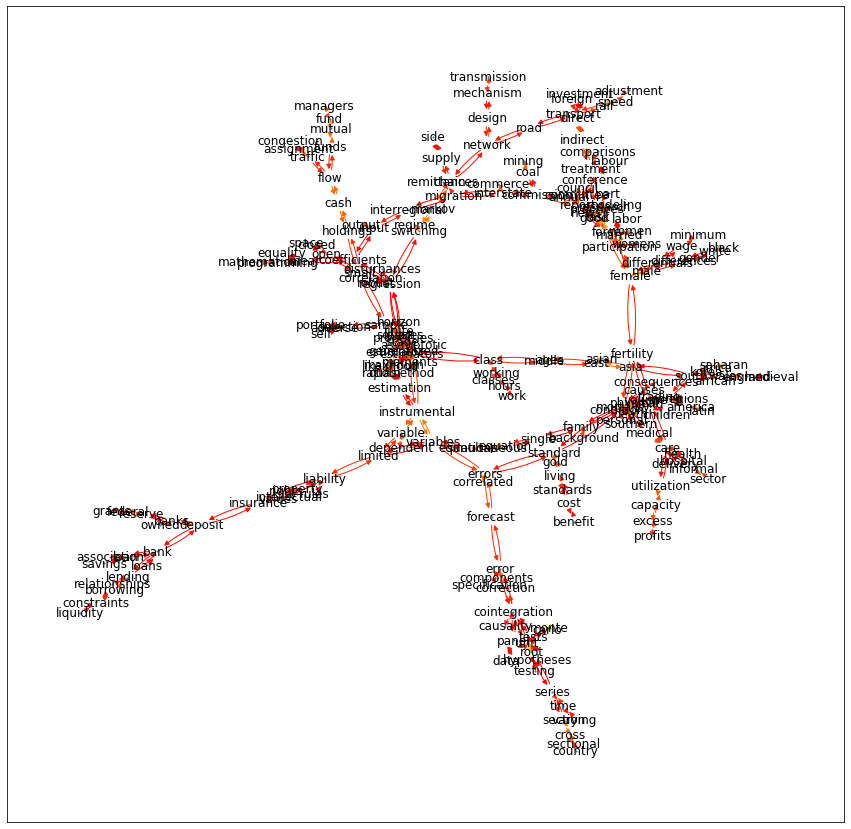

In [111]:
R, C = 1,1 # size of plot

nodes_list = list(nx.connected_components(G.to_undirected()))
nodes_list = sorted(nodes_list, key=lambda x:-len(x))

x_off = 0.1
y_off = 0.1

plt.figure(figsize=(15*R,15*C))

for i,Gcomp_nodes in enumerate(nodes_list[:R*C]):
    plt.subplot(R,C,i+1)
    Gcomp = nx.subgraph(G, Gcomp_nodes)
    pos = nx.spring_layout(Gcomp, iterations=150, k=0.5)
    pos_offset = {k:([v[0]+x_off, v[1]+y_off]) for k,v in pos.items()} # not currently used


    edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(Gcomp,'weight').items()])

    c = np.log(weights)
    c /= c.max()

    nx.draw_networkx_edges(Gcomp,pos,edgelist=edges,edge_cmap=plt.cm.autumn,edge_color=c,
        connectionstyle="arc3,rad=0.1")
    nx.draw_networkx_nodes(Gcomp,pos,node_size=1)
    nx.draw_networkx_labels(Gcomp,pos)

# noticing extreme structural similarity

I keep trying to plot these networks and notice multiple nodes which lie exactly on top of each other.
They have very strong ties to each other, and the same ties to other blocks.

The following simply orders the nodes by pairwise iterative simularity, and shows the reordered matrix using `imshow`.
It's clear we need to be clustering all the time.

In [90]:
from sklearn.metrics import pairwise_distances

In [91]:
items = sorted(pos.keys())
vals = np.array( [pos[k] for k in items] )

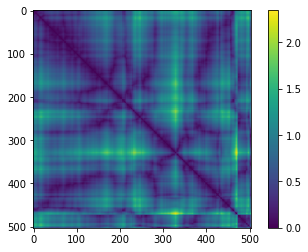

In [92]:
all_ds = pairwise_distances(vals)

new_order = [0]
while len(new_order) < vals.shape[0]:
    ds = all_ds[new_order[-1], :]
    for i in np.argsort(ds):
        if i == new_order[-1]:
            continue
        if i in new_order:
            continue
        new_order.append(i)
        break

ordered_ds = all_ds[new_order,:]
ordered_ds = ordered_ds[:,new_order]
plt.imshow(ordered_ds)
plt.colorbar()

In [93]:
ordered_items = [items[i] for i in new_order]
ordered_items[:5]

['achievement', 'teachers', 'student', 'teacher', 'college']

In [94]:
#iterative_d = [ ordered_ds[i,i+1] for i in range(ordered_ds.shape[0]-1) ]
clusters = []
current_c = [0]
for i in range(0,ordered_ds.shape[0]-1):
    if ordered_ds[i,i+1] < 0.3:
        current_c.append(i+1)
    else:
        clusters.append(current_c)
        current_c = [i+1]

In [95]:
for ci, c in enumerate(clusters):
    print(f"Cluster {ci+1}")
    for i in c:
        print(f"+ {ordered_items[i]}")
    print("")

Cluster 1
+ achievement
+ teachers
+ student
+ teacher
+ college
+ students
+ schools
+ frequency
+ high
+ period
+ school
+ test
+ multi
+ region
+ hypothesis
+ fluctuations
+ cyclical
+ temporary
+ permanent
+ income
+ effectiveness
+ benefit
+ cost
+ retail
+ standards
+ living
+ criteria
+ latin
+ america
+ regions
+ east
+ asian
+ asia
+ making
+ india
+ alternative
+ decision
+ hypotheses
+ data
+ monte
+ carlo
+ causality
+ specification
+ components
+ correction
+ cointegration
+ tests
+ testing
+ panel
+ background
+ forecast
+ family
+ root
+ unit
+ correlation
+ robust
+ medical
+ rules
+ error
+ child
+ single
+ mortality
+ condition
+ death
+ personal
+ southern
+ influence
+ causes
+ consequences
+ standard
+ gold
+ north
+ correlated
+ ages
+ errors
+ middle
+ variables
+ equations
+ equation
+ simultaneous
+ instrumental
+ squares
+ least
+ class
+ stage
+ generalized
+ moments
+ method
+ maximum
+ likelihood
+ quasi
+ estimation
+ estimator
+ estimators
+ asymptotic
+ 